# ELR Python example usage

Emile Esmaili

In [33]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import ELR as ELR
import pandas as pd
import subprocess
import os
import cartopy.crs as ccrs

In [34]:
if not os.path.exists('download'):
    os.makedirs('download')

## Download example data from IRI

Model: We will use CRPV2 precip forecast over AP domain

In [ ]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

download = True
if download == True:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])

cfsv2 = xr.open_dataset(cfsv2_path)
cfsv2['S'] = pd.to_datetime(cfsv2['S'].values)

Selecting lead time

In [36]:
#select lead time
lead_time = 0
cfsv2 = cfsv2.isel(L=lead_time)

S_values = cfsv2['S'].values
T_values = [S_value + pd.DateOffset(months=lead_time) for S_value in S_values]
cfsv2['T'] = T_values
cfsv2 = cfsv2.assign_coords(T=('S', T_values)).swap_dims(S='T')
#drop S
cfsv2 = cfsv2.drop_vars('S')


Observations: CMAP 1x1

In [37]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")

https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [38]:
# make both arrays same time range
cmap = cmap.sel(T=slice(cfsv2['T'].min(), cfsv2['T'].max()))
cfsv2 = cfsv2.sel(T=slice(cmap['T'].min(), cmap['T'].max()))
assert np.all(cmap['T'].values == cfsv2['T'].values)


## Using the ELR module

In [39]:
X = cfsv2['prec']
y = cmap['prcp_est']

# Initialize and train the model
elr = ELR.ELR(window=12) #choose weekly window size for correcting the season cycle, we will use 12 weeks ie a season
elr.fit(X, y) #fit ELR to each grid point 

# Make predictions
predictions = elr.predict(X, y)


## Looking at the results quickly

First let's see the ensemble mean at the last period

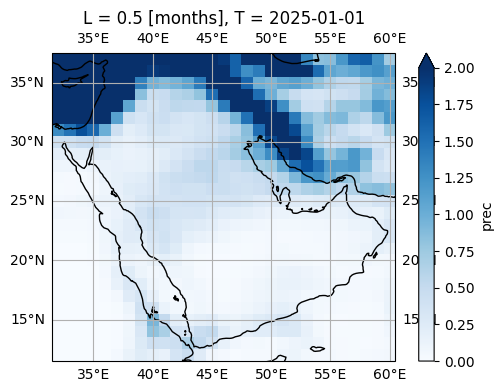

In [40]:
# Create a Plate Carrée projection (equirectangular)
projection = ccrs.PlateCarree()

# Create a figure with 1 subplot
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': projection})

# Plot the data using the Plate Carrée projection
X.mean(dim='M').isel(T=-1).plot(ax=ax, cmap='Blues', vmax=2, transform=projection)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add coastlines and gridlines for reference
ax.coastlines()
ax.gridlines(draw_labels=True)

**Now let's see the probability of each category** 

*Note that we use a mask when q33 and q66 are equal, as well as when q33 is 0*

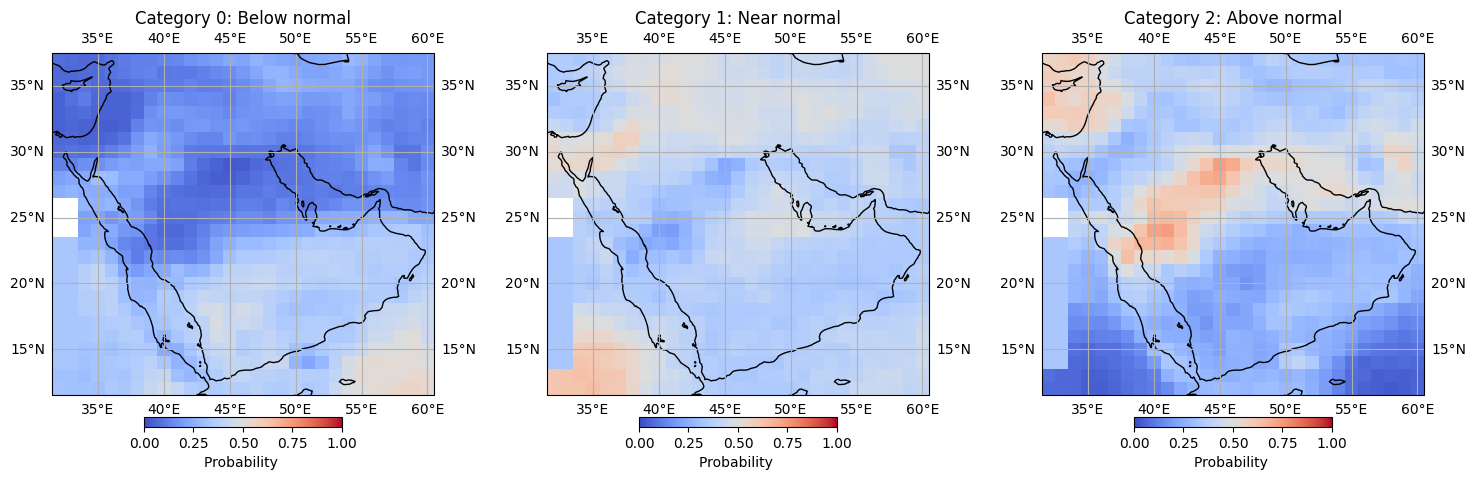

In [41]:
# Create a Plate Carrée projection (equirectangular)
projection = ccrs.PlateCarree()

# Create a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': projection})

# Plot each category (0, 1, 2) in a separate subplot
categories = [0, 1, 2]
for i, cat in enumerate(categories):
    # Plot data using the Plate Carrée projection
    ax = axes[i]
    predictions.isel(T=-1, category=cat).plot(ax=ax, transform=projection, cmap='coolwarm', vmin=0, vmax=1,
                                              cbar_kwargs={'label': 'Probability ', 'orientation': 'horizontal',
                                                                                            'pad': 0.05, 'shrink': 0.5})
    categories = ['Below normal', 'Near normal', 'Above normal']
    # Set title and labels
    ax.set_title(f"Category {cat}: {categories[cat]}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Add coastlines and gridlines for reference
    ax.coastlines()
    ax.gridlines(draw_labels=True)

# Adjust layout
plt.tight_layout()
plt.show()